# Notebook 2: Discovering themes in legal corpora using Latent Dirichlet Allocation (Topic modeling for historical texts)

Legal judgments are complex documents that draw upon many facets of legal reasoning, including the interpretation of applicable law, evaluation of evidence presented in court, and consideration of prior precedents. This makes them difficult to systemically analyze as they often defy single membership classification. Rice (2019) introduces Latent Dirichlet Allocation as a method of unsupervised structured topic modelling (STM), allowing for underlying themes in legal texts to be uncovered via a computational approach and capture the proportionate attention given to multiple legal dimensions within each judgement. 

In [1]:
    import pandas as pd
import json
import pathlib
import re, string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import multiprocessing

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from typing import List

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/randyzhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/randyzhu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. What exactly *is* LDA?

[explainer for LDA goes here]


### 1.1 A simple LDA workflow example

In [2]:
import src.prototype_ipy_explotest
%load_ext src.prototype_ipy_explotest

In [3]:
start_year = 1877  # First year of data sought (1877 +)
end_year = 2024  # Last year of data sought (2024 -)


# Set path to data
data_path = pathlib.Path('../scc_bulk_data/DATA/YEARLY/')

# load data (all years, json files)
results = []
for year in range(start_year, end_year+1):
    with open(data_path / f'{year}.json') as f:
        results.extend(json.load(f))

# convert to dataframe
df = pd.DataFrame(results)
df.head()

,citation,citation2,dataset,year,name,language,document_date,source_url,scraped_timestamp,unofficial_text,other
0,(1877) 1 SCR 110,,SCC,1877,Boak et al. v. The Merchant's Marine Insurance...,en,1877-01-23,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Boak et al. v. The Merchant's Marine Insurance...,
1,(1877) 1 SCR 114,,SCC,1877,Smyth v. McDougall,en,1877-02-01,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Smyth v. McDougall\nCollection\nSupreme Court ...,
2,(1877) 1 SCR 117,,SCC,1877,The Queen v. Laliberté,en,1877-02-03,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,The Queen v. Laliberté\nCollection\nSupreme Co...,
3,(1877) 1 SCR 145,,SCC,1877,Brassard et al. v. Langevin,en,1877-02-28,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Brassard et al. v. Langevin\nCollection\nSupre...,
4,(1877) 1 SCR 235,,SCC,1877,Johnstone v. The Minister & Trustees of St. An...,en,1877-06-28,https://decisions.scc-csc.ca/scc-csc/scc-csc/e...,2022-08-31,Johnstone v. The Minister & Trustees of St. An...,


In [4]:
df['length'] = df['unofficial_text'].apply(
    lambda row: min(len(row.split(" ")), len(row)) if isinstance(row, str) else None
)

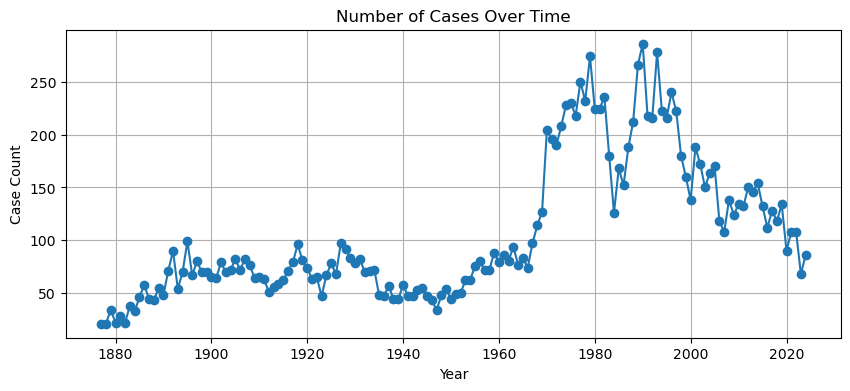

In [5]:
def plot_case_distribution(df):
    """
    Plot the number of cases over time 
    """
    df['document_date'] = pd.to_datetime(df['document_date'])
    counts = df.set_index('document_date').resample('YE').size()
    plt.figure(figsize=(10,4))
    plt.plot(counts.index.year, counts.values, marker='o')
    plt.title('Number of Cases Over Time')
    plt.xlabel('Year')
    plt.ylabel('Case Count')
    plt.grid(True)
    plt.show()

plot_case_distribution(df)  


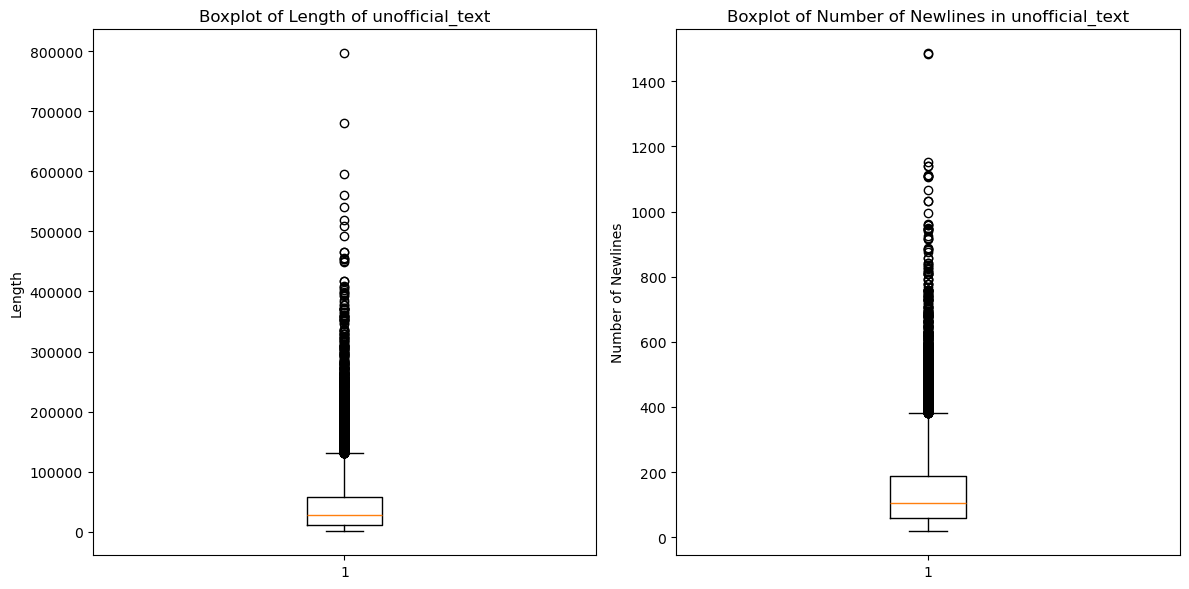

In [6]:
# Calculate the length of 'unofficial_text' for each row
df['unofficial_text_length'] = df['unofficial_text'].str.len()

# Calculate the number of newline characters in 'unofficial_text' for each row
df['unofficial_text_newlines'] = df['unofficial_text'].str.count(r'\n')

# Create a figure with two subplots (one for each boxplot)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for the length of unofficial_text
axes[0].boxplot(df['unofficial_text_length'])
axes[0].set_title('Boxplot of Length of unofficial_text')
axes[0].set_ylabel('Length')

# Boxplot for the number of newline characters in unofficial_text
axes[1].boxplot(df['unofficial_text_newlines'])
axes[1].set_title('Boxplot of Number of Newlines in unofficial_text')
axes[1].set_ylabel('Number of Newlines')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [7]:
df_english = df[df['language'] == 'en']

In [8]:
LEMMA = WordNetLemmatizer()

en_stop = set(stopwords.words('english'))
fr_stop = set(stopwords.words('french')) # we need a better french stopword corpus.....
custom_stop = {'from', 'subject', 're', 'edu', 'thereof', 'herein',
               'hereby', 'aforesaid', 'whereas', 'shall', 'henceforth',
               'article', 'section', 'v'}
stop_words = en_stop | fr_stop | custom_stop

def cleanup_text(s: str, lemmatize=True):
    """
    Initial cleanup function for demo-ing wordcloud
    """
    if not isinstance(s, str):
        return ""
    s = s.lower().replace('\r\n',' ').replace('\n',' ')
    s = re.sub(r'\s+', ' ', s).strip()
    s = s.translate(str.maketrans('', '', string.punctuation))
    tokens = []
    for w in s.split():
        if len(w) <= 1 or w in stop_words:
            continue
        tok = LEMMA.lemmatize(w) if lemmatize else w
        if not re.fullmatch(r'[a-z]+', tok):
            continue
        tokens.append(tok)
    return tokens


In [9]:
cleanup_text(df['unofficial_text'].iloc[1])

['smyth',
 'mcdougall',
 'collection',
 'supreme',
 'court',
 'judgment',
 'date',
 'report',
 'scr',
 'judge',
 'ritchie',
 'william',
 'johnstone',
 'strong',
 'samuel',
 'henry',
 'taschereau',
 'fournier',
 'henry',
 'william',
 'alexander',
 'appeal',
 'nova',
 'scotia',
 'subject',
 'evidence',
 'decision',
 'content',
 'court',
 'canada',
 'smyth',
 'mcdougall',
 'scr',
 'date',
 'honorable',
 'peter',
 'smyth',
 'appellant',
 'elizabeth',
 'mcdougall',
 'suggesting',
 'death',
 'thomas',
 'mooney',
 'respondent',
 'february',
 'chief',
 'justice',
 'ritchie',
 'strong',
 'taschereau',
 'fournier',
 'henry',
 'jj',
 'appeal',
 'supreme',
 'court',
 'nova',
 'scotia',
 'special',
 'evidence',
 'case',
 'consent',
 'party',
 'turned',
 'special',
 'case',
 'judge',
 'minute',
 'evidence',
 'taken',
 'trial',
 'agreed',
 'considered',
 'part',
 'said',
 'special',
 'case',
 'court',
 'power',
 'add',
 'anything',
 'thereto',
 'except',
 'like',
 'consent',
 'power',
 'order',
 'evi

In [10]:
data_tokens = [cleanup_text(doc) for doc in df['unofficial_text']]

(-0.5, 799.5, 399.5, -0.5)

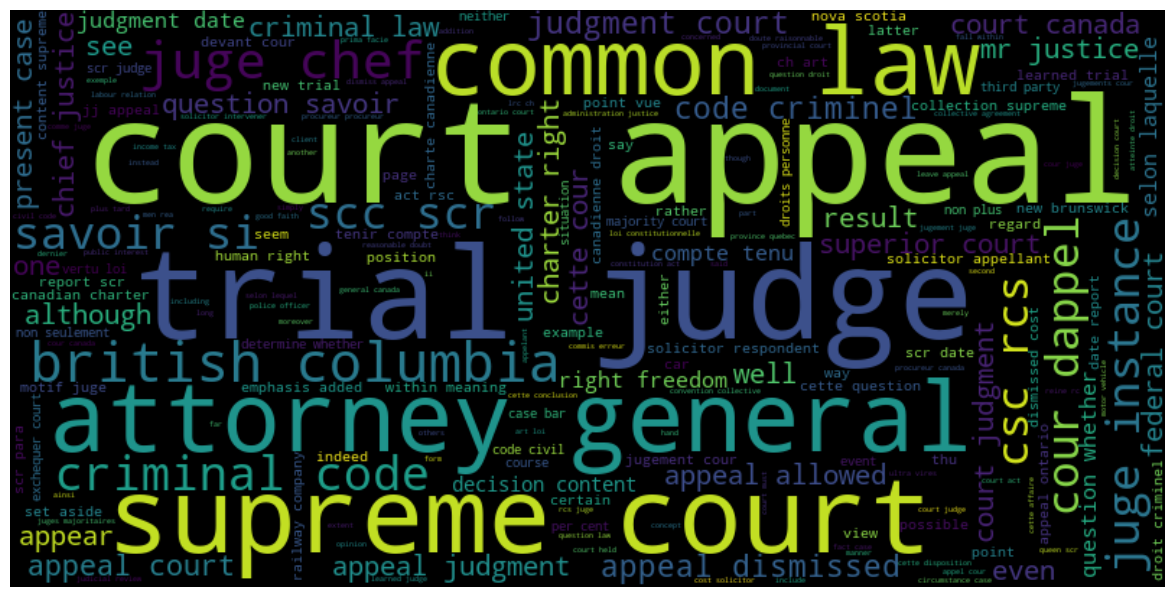

In [11]:
all_text = ' '.join([' '.join(tokens) for tokens in data_tokens])
wordcloud = WordCloud(width=800, height=400).generate(all_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [12]:
df_english['clean_text'] = df_english['unofficial_text'].apply(cleanup_text)

/var/folders/nq/__4wtwjx6p305nltpgvv7ct00000gn/T/ipykernel_36629/4304061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_english['clean_text'] = df_english['unofficial_text'].apply(cleanup_text)


In [13]:
print(df_english['clean_text'])

0        [boak, al, merchant, marine, insurance, compan...
1        [smyth, mcdougall, collection, supreme, court,...
2        [queen, collection, supreme, court, judgment, ...
3        [brassard, al, langevin, collection, supreme, ...
4        [johnstone, minister, trustee, st, andrew, chu...
                               ...                        
15659    [reference, act, respecting, first, nation, in...
15660    [bykovets, collection, supreme, court, judgmen...
15661    [kruk, collection, supreme, court, judgment, d...
15662    [yatar, td, insurance, meloche, monnex, collec...
15663    [boudreau, collection, supreme, court, judgmen...
Name: clean_text, Length: 10758, dtype: object


In [16]:

default_stop_words = en_stop | fr_stop | custom_stop

def preprocess_texts(df, stop_words, text_col="unofficial_text", lemmatize=True) -> List[List[str]]:
    """
    Tokenize, remove stopwords/punctuation, and optionally lemmatize the texts 
    Returns list of token lists
    - lemmatize: if True, apply WordNet lemmatizer
    """
    texts = df[text_col].astype(str).tolist()
    sw = stop_words if stop_words is not None else default_stop_words
    lemmatizer = WordNetLemmatizer()
    processed = []
    for doc in texts:
        tokens = []
        text = doc.lower().replace("\n", " ")
        text = re.sub(r"\s+", " ", text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        for token in simple_preprocess(text, deacc=True, min_len=3):
            if token in sw:
                continue
            if lemmatize:
                token = lemmatizer.lemmatize(token)
            tokens.append(token)
        processed.append(tokens)
    return processed

NameError: name 'List' is not defined

In [ ]:
tokenized_texts = preprocess_texts(df,text_col='unofficial_text')

In [ ]:
print(tokenized_texts[0:10])

In [ ]:
def make_bigrams(tokenized_texts, min_count=10, threshold=50):
    """
    Fit a bigram phraser and apply to tokenized texts
    """
    phrases = Phrases(tokenized_texts, min_count=min_count, threshold=threshold)
    bigram_mod = Phraser(phrases)
    return [bigram_mod[doc] for doc in tokenized_texts]

In [ ]:
bigrams_list = make_bigrams(tokenized_texts)

In [ ]:
print(bigrams_list[0:3])

In [ ]:
all_text_bigrams = ' '.join([' '.join(tokens) for tokens in bigrams_list])
wordcloud = WordCloud(width=800, height=400).generate(all_text_bigrams )
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [ ]:
def create_dictionary_corpus(texts, no_below=15, no_above=0.5):
    """
    Build Gensim dictionary and corpus from tokenized texts
    """
    id2word = Dictionary(texts)
    id2word.filter_extremes(no_below=no_below, no_above=no_above)
    corpus = [id2word.doc2bow(text) for text in texts]
    return id2word, corpus

id2word, corpus = create_dictionary_corpus(bigrams_list)

In [ ]:
def train_lda(corpus, id2word, num_topics=25, passes=10, iterations=50, workers=None):
    """
    Train da model
    """
    workers = max(1, multiprocessing.cpu_count()-1)
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        num_topics=25,
        random_state=1975,
        chunksize=20000,      # larger chunk → fewer Python callbacks
        passes=10,            # fewer full-corpus passes
        iterations=50,       # enough for convergence
        eval_every=None,     # disable perplexity eval (slow)
        workers=workers,
        alpha='asymmetric',  # faster convergence in many cases
        eta='auto',
        per_word_topics=False
    )
    return lda_model

In [ ]:
lda = train_lda(corpus=corpus,id2word=id2word, num_topics=20,passes=15,iterations=100)

In [ ]:
def compute_coherence_values(corpus, id2word, texts, start=5, limit=30, step=5):
    """
    Compute coherence values for various number of topics
    """
    coherences = []
    model_list = []
    for num in range(start, limit+1, step):
        model = train_lda(corpus, id2word, num_topics=num)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherences.append(coherencemodel.get_coherence())
    plt.figure()
    plt.plot(range(start, limit+1, step), coherences)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence vs Number of Topics")
    plt.show()
    return model_list, coherences

In [ ]:
compute_coherence_values(corpus, id2word, all_text_bigrams)

In [ ]:
print(lda.print_topics())

In [ ]:
def display_topics(model, num_words=50):
    """
    Print top words for each topic
    """
    for idx, topic in model.show_topics(formatted=False, num_words=num_words):
        words = [word for word, _ in topic]
        print(f"Topic {idx}: {words}")
        
display_topics(lda)

In [ ]:
def plot_top_words(lda_model, num_words=10):
    for i, topic in lda_model.show_topics(formatted=False, num_words=num_words):
        words, probs = zip(*topic)
        plt.figure(figsize=(8, 4))
        plt.barh(words, probs)
        plt.title(f'Topic {i}')
        plt.gca().invert_yaxis()
        plt.xlabel('Probability')
        plt.tight_layout()
        plt.show()

plot_top_words(lda)


In [ ]:
def plot_topic_wordclouds(model, id2word, num_topics=20, width=400, height=200):
    """
    Generate and display a wordcloud for each topic
    """
    for t in range(num_topics):
        plt.figure()
        plt.axis('off')
        word_probs = dict(model.show_topic(t, topn=50))
        wc = WordCloud(width=width, height=height)
        wc.generate_from_frequencies(word_probs)
        plt.title(f"Topic {t} Wordcloud")
        plt.imshow(wc, interpolation='bilinear')
        plt.show()

plot_topic_wordclouds(lda, id2word)

In [ ]:
def plot_cases_by_topic_over_time():
    